 Archivo input: (Si se ejecuta la celda se obtiene el grafo "grafo_prendas.gexf")

In [ ]:
import os
import requests
import torch
import numpy as np
import pandas as pd
import networkx as nx
import torch_geometric.transforms as T
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Iniciando en: {device}")

url = "https://raw.githubusercontent.com/naaiaafernaandez/Reto_10_Azul_Oscuro/main/grafo_prendas.gexf"
archivo_local = "grafo_prendas.gexf"
if os.path.exists(archivo_local):
    os.remove(archivo_local)

print(f"Descargando grafo...")
response = requests.get(url)
if response.status_code == 200:
    with open(archivo_local, 'wb') as f:
        f.write(response.content)
    print("Descarga completada.")
else:
    raise Exception(f"Error descarga: {response.status_code}")
graph = nx.read_gexf(archivo_local)
print(f"📈 Grafo cargado: {len(graph.nodes)} nodos.")

print("\n--- INICIANDO PROCESAMIENTO DE VARIABLES ---")
data = from_networkx(graph)
nodes_data = list(graph.nodes(data=True))
num_vars = ['nivel','color_nivel']
cat_vars = ['talla','sub_category','tiempo','styles','prints','fits']
num_features = []
for var in num_vars:
    raw_values = [float(n[1].get(var, 0.0)) for n in nodes_data] # Aseguramos float
    col_values = np.array(raw_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    col_values = scaler.fit_transform(col_values)
    num_features.append(col_values)
cat_features = []
for var in cat_vars:
    raw_values = [str(n[1].get(var, 'unknown')) for n in nodes_data]
    encoder = LabelEncoder()
    col_values = encoder.fit_transform(raw_values)
    col_values = col_values.reshape(-1, 1)
    cat_features.append(col_values)
all_features = np.hstack(num_features + cat_features)
data.x = torch.tensor(all_features, dtype=torch.float)
print(f"Matriz de características creada: {data.x.shape} (Nodos x 8 Features)")
attributes_to_remove = []
for key in data.keys():
    if key not in ['edge_index', 'x', 'y', 'num_nodes', 'edge_label', 'edge_label_index']:
        attributes_to_remove.append(key)
for key in attributes_to_remove:
    if hasattr(data, key):
        delattr(data, key)
split = RandomLinkSplit(
    num_val=0.1,    
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=2.0,)
train_data, val_data, test_data = split(data)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
print("Datos divididos y listos para entrenar.")

🚀 Iniciando en: cpu
⬇️ Descargando grafo...
✅ Descarga completada.
📈 Grafo cargado: 7555 nodos.

--- INICIANDO PROCESAMIENTO DE VARIABLES ---
✅ Matriz de características creada: torch.Size([7555, 8]) (Nodos x 8 Features)
✅ Datos divididos y listos para entrenar.


Entrenando modelo GCN

In [ ]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

class NetGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GCN (Nuevas Features)...")
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_gnn_final.pth')

🏁 Entrenando GCN (Nuevas Features)...
Epoch: 020, Loss: 1.8793, Val AUC: 0.7468
Epoch: 040, Loss: 0.6808, Val AUC: 0.7881
Epoch: 060, Loss: 0.6434, Val AUC: 0.7953
Epoch: 080, Loss: 0.6344, Val AUC: 0.8107
Epoch: 100, Loss: 0.6270, Val AUC: 0.8180
Epoch: 120, Loss: 0.6200, Val AUC: 0.8281
Epoch: 140, Loss: 0.6138, Val AUC: 0.8372
Epoch: 160, Loss: 0.6080, Val AUC: 0.8451
Epoch: 180, Loss: 0.6020, Val AUC: 0.8530
Epoch: 200, Loss: 0.5966, Val AUC: 0.8607
Epoch: 220, Loss: 0.5906, Val AUC: 0.8681
Epoch: 240, Loss: 0.5848, Val AUC: 0.8750
Epoch: 260, Loss: 0.5787, Val AUC: 0.8815
Epoch: 280, Loss: 0.5730, Val AUC: 0.8870
Epoch: 300, Loss: 0.5675, Val AUC: 0.8917


📊 Generando Gráficas para GCN...


C:\Users\carlo\AppData\Local\Temp\ipykernel_12636\493807430.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_gnn_final.pth', map_

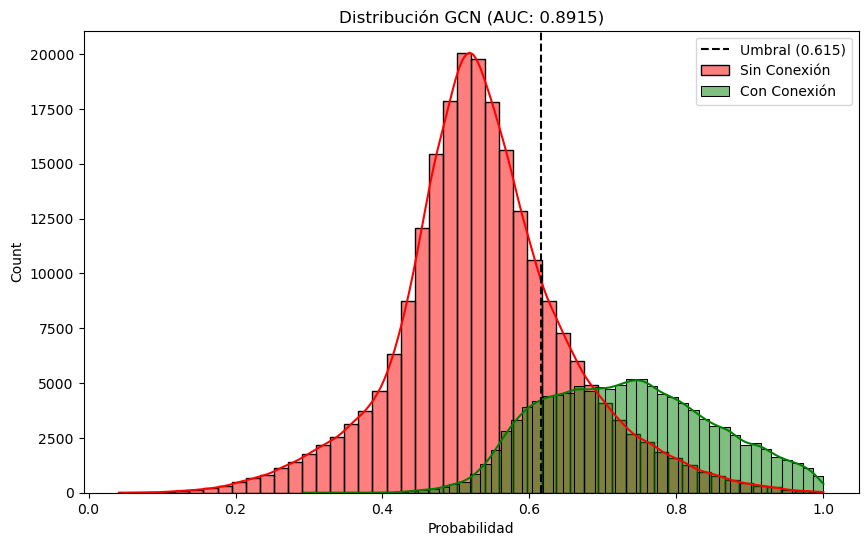

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("Generando Gráficas para GCN...")
model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_gnn_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='green', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución GCN (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

Entrenando modelo GAT

In [ ]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class NetGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True, dropout=0.1)
        self.conv2 = GATConv(hidden_channels * 2, out_channels, heads=1, concat=False, dropout=0.1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGAT(in_channels=data.num_features, hidden_channels=64, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GAT (Nuevas Features)...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_gat_final.pth')

🏁 Entrenando GAT (Nuevas Features)...
Epoch: 020, Loss: 2.3134, Val AUC: 0.4522
Epoch: 040, Loss: 0.9327, Val AUC: 0.5378
Epoch: 060, Loss: 0.7120, Val AUC: 0.6658
Epoch: 080, Loss: 0.6662, Val AUC: 0.7053
Epoch: 100, Loss: 0.6494, Val AUC: 0.7242
Epoch: 120, Loss: 0.6408, Val AUC: 0.7389
Epoch: 140, Loss: 0.6341, Val AUC: 0.7487
Epoch: 160, Loss: 0.6294, Val AUC: 0.7553
Epoch: 180, Loss: 0.6260, Val AUC: 0.7617
Epoch: 200, Loss: 0.6232, Val AUC: 0.7662
Epoch: 220, Loss: 0.6202, Val AUC: 0.7699
Epoch: 240, Loss: 0.6174, Val AUC: 0.7750
Epoch: 260, Loss: 0.6153, Val AUC: 0.7784
Epoch: 280, Loss: 0.6132, Val AUC: 0.7831
Epoch: 300, Loss: 0.6110, Val AUC: 0.7875


📊 Generando Gráficas para GAT...


C:\Users\carlo\AppData\Local\Temp\ipykernel_12636\291833452.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_gat_final.pth', map_

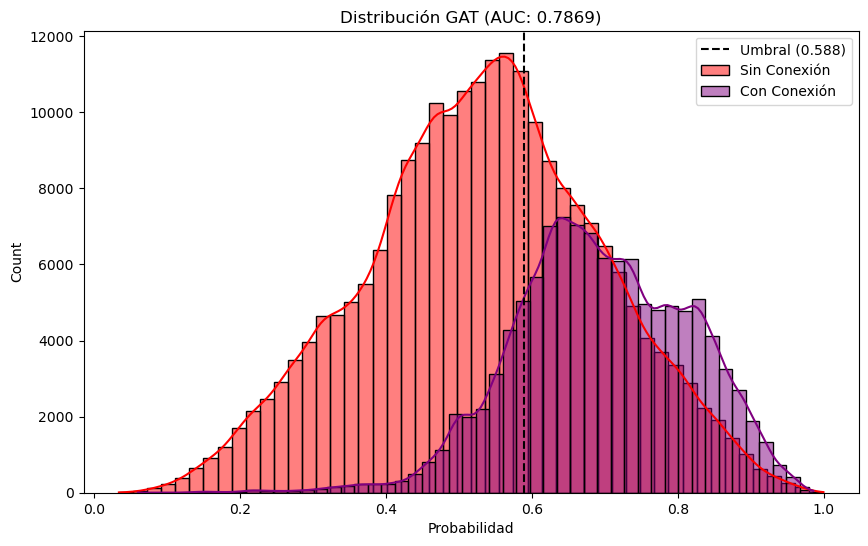

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Re-importamos para arreglar el error

print("Generando Gráficas para GAT...")
model = NetGAT(in_channels=data.num_features, hidden_channels=64, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_gat_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='purple', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución GAT (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

Entrenando modelo GraphSAGE

In [ ]:
from torch_geometric.nn import SAGEConv

class NetSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetSAGE(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GraphSAGE (Nuevas Features)...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_sage_final.pth')

🏁 Entrenando GraphSAGE (Nuevas Features)...
Epoch: 020, Loss: 9.1834, Val AUC: 0.3157
Epoch: 040, Loss: 1.0366, Val AUC: 0.2785
Epoch: 060, Loss: 0.7990, Val AUC: 0.3778
Epoch: 080, Loss: 0.7407, Val AUC: 0.4782
Epoch: 100, Loss: 0.7181, Val AUC: 0.5486
Epoch: 120, Loss: 0.7063, Val AUC: 0.5959
Epoch: 140, Loss: 0.6995, Val AUC: 0.6306
Epoch: 160, Loss: 0.6916, Val AUC: 0.6576
Epoch: 180, Loss: 0.6863, Val AUC: 0.6801
Epoch: 200, Loss: 0.6827, Val AUC: 0.6977
Epoch: 220, Loss: 0.6785, Val AUC: 0.7123
Epoch: 240, Loss: 0.6760, Val AUC: 0.7245
Epoch: 260, Loss: 0.6740, Val AUC: 0.7351
Epoch: 280, Loss: 0.6718, Val AUC: 0.7441
Epoch: 300, Loss: 0.6682, Val AUC: 0.7526


📊 Generando Gráficas para GraphSAGE...


C:\Users\carlo\AppData\Local\Temp\ipykernel_12636\3968662859.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_sage_final.pth', ma

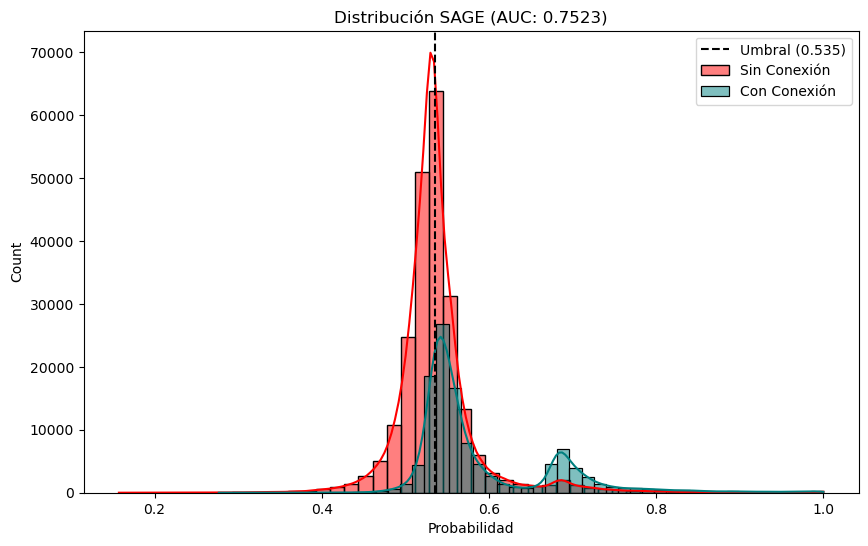

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Re-import por seguridad

print("Generando Gráficas para GraphSAGE...")
model = NetSAGE(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_sage_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='teal', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución SAGE (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

📊 Comparativa Final (Features Correctas)...


C:\Users\carlo\AppData\Local\Temp\ipykernel_12636\1064823224.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

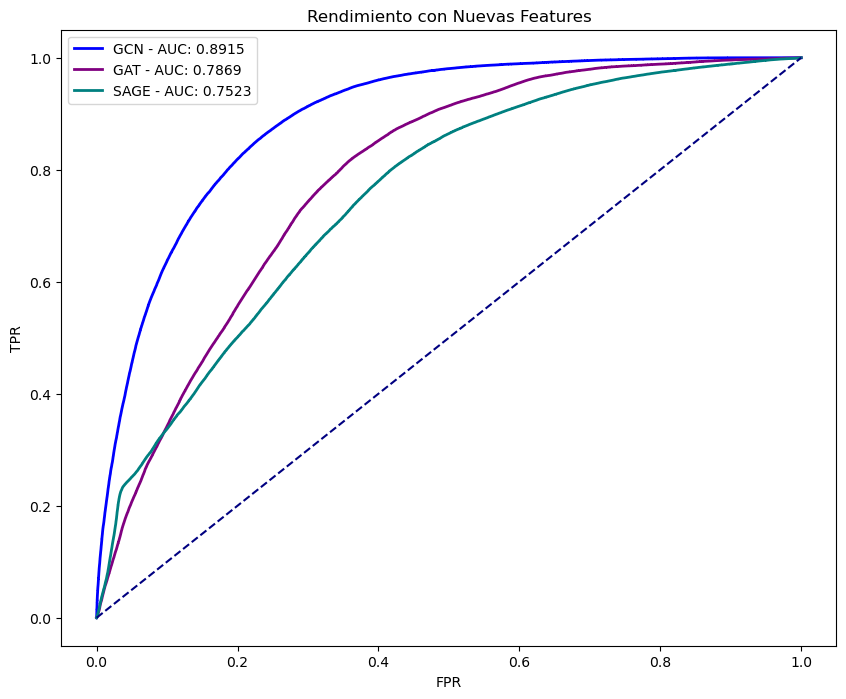

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

modelos = [
    ("GCN", NetGCN, 'Modelos/modelo_gnn_final.pth', {'hidden_channels': 128}),
    ("GAT", NetGAT, 'Modelos/modelo_gat_final.pth', {'hidden_channels': 64}),
    ("SAGE", NetSAGE, 'Modelos/modelo_sage_final.pth', {'hidden_channels': 128})
]

plt.figure(figsize=(10, 8))
colors = ['blue', 'purple', 'teal']

print("Comparativa Final (Features Correctas)...")

for i, (name, cls, path, args) in enumerate(modelos):
    model = cls(in_channels=data.num_features, out_channels=64, **args).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
        fpr, tpr, _ = roc_curve(test_data.edge_label.cpu().numpy(), out.cpu().numpy())
        score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{name} - AUC: {score:.4f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Rendimiento con Nuevas Features')
plt.legend(); plt.show()

GCN con 1000 epocas+scheduler

In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

class NetGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=0.00001)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GCN 'Long Run' (1000 épocas)...")

for epoch in range(1, 1001):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(
        train_data.edge_index, 
        num_nodes=train_data.num_nodes, 
        num_neg_samples=train_data.edge_label_index.size(1), 
        method='sparse')
    
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch:04d}, Loss: {loss:.4f}, Val AUC: {auc:.4f} | LR Actual: {current_lr:.4g}")
torch.save(model.state_dict(), 'Modelos/modelo_gnn_1000.pth')
print("Modelo GCN (1000 épocas) guardado como: modelo_gnn_1000.pth")

🏁 Entrenando GCN 'Long Run' (1000 épocas)...
Epoch: 0020, Loss: 1.8676, Val AUC: 0.7661 | LR Actual: 0.01
Epoch: 0040, Loss: 0.7130, Val AUC: 0.7157 | LR Actual: 0.01
Epoch: 0060, Loss: 0.6672, Val AUC: 0.8011 | LR Actual: 0.01
Epoch: 0080, Loss: 0.6559, Val AUC: 0.8466 | LR Actual: 0.01
Epoch: 0100, Loss: 0.6457, Val AUC: 0.8693 | LR Actual: 0.01
Epoch: 0120, Loss: 0.6355, Val AUC: 0.8792 | LR Actual: 0.01
Epoch: 0140, Loss: 0.6258, Val AUC: 0.8850 | LR Actual: 0.01
Epoch: 0160, Loss: 0.6172, Val AUC: 0.8902 | LR Actual: 0.01
Epoch: 0180, Loss: 0.6092, Val AUC: 0.8947 | LR Actual: 0.01
Epoch: 0200, Loss: 0.6022, Val AUC: 0.8982 | LR Actual: 0.01
Epoch: 0220, Loss: 0.5957, Val AUC: 0.9009 | LR Actual: 0.01
Epoch: 0240, Loss: 0.5890, Val AUC: 0.9034 | LR Actual: 0.01
Epoch: 0260, Loss: 0.5828, Val AUC: 0.9056 | LR Actual: 0.01
Epoch: 0280, Loss: 0.5764, Val AUC: 0.9077 | LR Actual: 0.01
Epoch: 0300, Loss: 0.5704, Val AUC: 0.9095 | LR Actual: 0.01
Epoch: 0320, Loss: 0.5639, Val AUC: 0.91

📊 Visualizando resultados de: modelo_gnn_1000.pth


C:\Users\carlo\AppData\Local\Temp\ipykernel_12636\3480531711.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_gnn_1000.pth', map

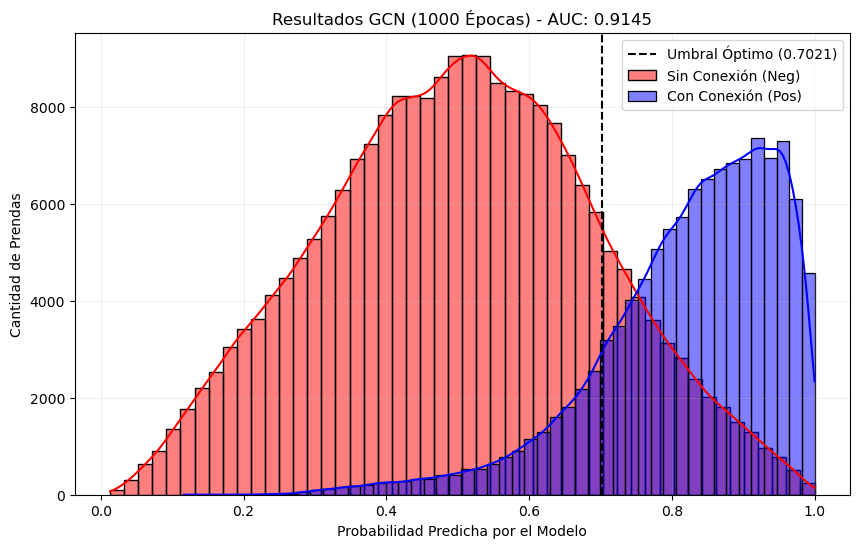

🔹 Accuracy Final: 0.8457
🔹 Mejor Umbral de Corte: 0.7021


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("Visualizando resultados de: modelo_gnn_1000.pth")

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_gnn_1000.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión (Neg)', bins=50, kde=True)
sns.histplot(preds_pos, color='blue', alpha=0.5, label='Con Conexión (Pos)', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral Óptimo ({best_threshold:.4f})')
plt.title(f'Resultados GCN (1000 Épocas) - AUC: {roc_auc:.4f}')
plt.xlabel('Probabilidad Predicha por el Modelo')
plt.ylabel('Cantidad de Prendas')
plt.legend()
plt.grid(alpha=0.2)
plt.show()
preds_opt = (y_scores > best_threshold).astype(int)
acc_opt = (preds_opt == y_true).sum() / len(y_true)
print(f"🔹 Accuracy Final: {acc_opt:.4f}")
print(f"🔹 Mejor Umbral de Corte: {best_threshold:.4f}")